# What trends do we see in the NYC restaurant inspections and what do we recommend to the customers

## Out line of the problem
- ### Use the NYC restaurant inspection data and make recommendations to the customers which type of restaurants have the lowest or highest risk.

## Approach

- ### Understand the inspection process. 

- ### Restaurants who scored low on initial inspection can ask for a re-inspection. Focus on the initial inspection scores.

- ### Identify restaurant types that are high or low risk based on the latest initial inspection.

## Summary

- ### Donuts shops and Cafes are low risk.

- ### Latin and Spanish cuisines are under represented in the low risk group.

- ### Spanish and Caribbean cuisines are over represented in the high risk group.

- ### For future iterations, check the effects of the location and price range.

- ### Fast foods, drinks, easy to serve foods are in the low risk group.

## Relevant analyses

In [98]:
#Import necessary packages

import numpy as np
import pandas as pd
import os

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sb
color = sb.color_palette()
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from sklearn import preprocessing as pp 
from sklearn.decomposition import PCA

import itertools

from scipy import linalg
import matplotlib as mpl

from sklearn import mixture

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from scipy.stats import pearsonr 

### Read in the data, check values

In [99]:
#Read the test_results.csv
current_path = os.getcwd()
file = '/datasets/NYC_Restaurant_Inspection/NYC_Restaurant_Inspection.csv'
NYC_inspection = pd.read_csv(current_path + file)

In [100]:
#Check null values
NYC_inspection.isnull().sum()

CAMIS                         0
DBA                         318
BORO                          0
BUILDING                    261
STREET                        1
ZIPCODE                    5485
PHONE                        17
CUISINE DESCRIPTION           0
INSPECTION DATE               0
ACTION                     1238
VIOLATION CODE             5531
VIOLATION DESCRIPTION      8923
CRITICAL FLAG              8923
SCORE                     16792
GRADE                    198299
GRADE DATE               200935
RECORD DATE                   0
INSPECTION TYPE            1238
Latitude                    414
Longitude                   414
Community Board            5898
Council District           5886
Census Tract               5886
BIN                        7639
BBL                         414
NTA                        5898
dtype: int64

In [101]:
#Drop rows that don't have score
NYC_inspection.dropna(subset=['SCORE'], inplace =True)

In [103]:
NYC_inspection.rename(columns = {'INSPECTION DATE':'INSPECTION_DATE'}, inplace = True)

### When restaurant doesn't get an "A" in inspection, they can apply for re-inspection. Which increases the number of "A". During this process, the restaurant will not have a grade.

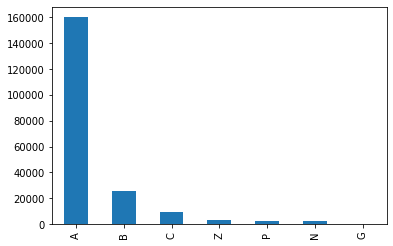

In [104]:
#Overall, most restaurants get an "A"
fig, ax = plt.subplots()
NYC_inspection['GRADE'].value_counts().plot(ax=ax, kind='bar')

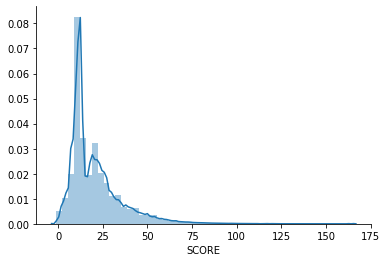

In [105]:
#SCORE has two peaks because scores larger than 14 in the initial inspection doesn't count?
sb.distplot(NYC_inspection['SCORE'])
sb.despine()

### Focus our analysis on the scores from the initial inspection. 

In [106]:
#Chose only the initial inspection.
Initial_inspection=NYC_inspection.loc[NYC_inspection['INSPECTION TYPE']=='Cycle Inspection / Initial Inspection']

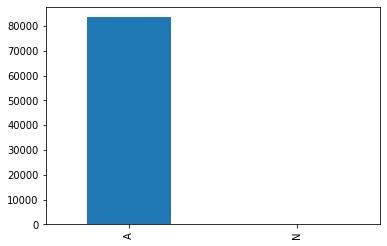

In [107]:
#For initial inspection, only those with "A" gets the grade (the rest of the restaurants apply for re-inspection)
fig, ax = plt.subplots()
Initial_inspection['GRADE'].value_counts().plot(ax=ax, kind='bar')

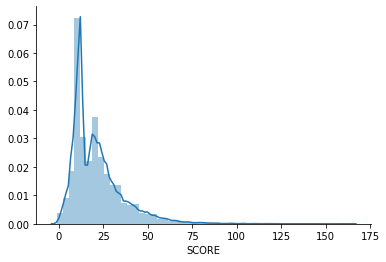

In [108]:
#We are still counting multiple inspections per site, and multiple rows per inspection.
sb.distplot(Initial_inspection['SCORE'])
sb.despine()

### We still have duplicates for each location. Chose only the latest initial inspection

In [109]:
#Group by CAMIS to get the latest initial inspection. There should still be multiple rows each corresponding to one violation.
latest_initial_inspection = Initial_inspection[Initial_inspection.groupby('CAMIS').INSPECTION_DATE.transform('max') == Initial_inspection['INSPECTION_DATE']]


In [110]:
#Drop the duplicates for each location (corresponds to each violation)
latest_initial_inspection.drop_duplicates(subset="CAMIS", keep="last",inplace=True)

/home/akira/anaconda3/envs/unsupervisedLearning/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [111]:
#Check the number of records in this dataset
latest_initial_inspection.shape

(22659, 26)

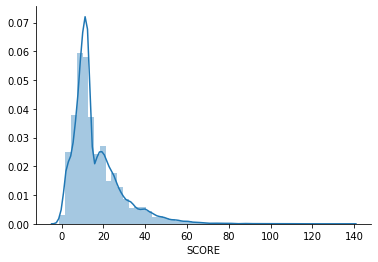

In [113]:
#Now we have one peak around 10
sb.distplot(latest_initial_inspection['SCORE'])
sb.despine()

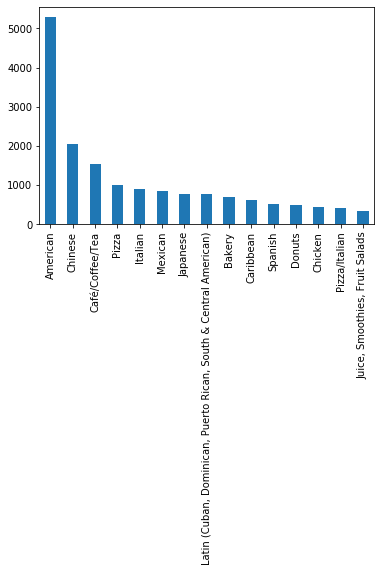

In [147]:
#We have many "Cuisine Description". Focus on top 15 descriptions.
fig, ax = plt.subplots()
latest_initial_inspection['CUISINE DESCRIPTION'].value_counts().head(15).plot(ax=ax, kind='bar')

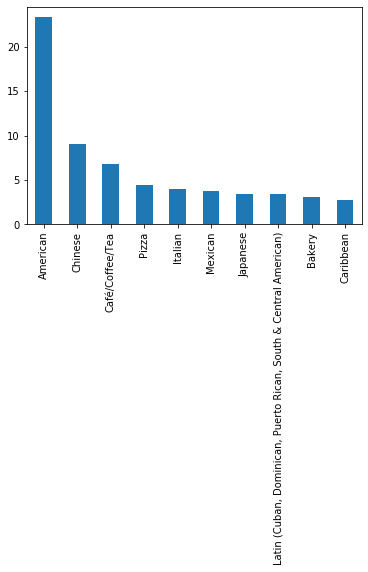

In [121]:
cuisine_counts=latest_initial_inspection['CUISINE DESCRIPTION'].value_counts()
cuisine_percentage=(cuisine_counts/22659)*100
fig, ax = plt.subplots()
cuisine_percentage.head(10).plot(ax=ax, kind='bar')

### Define low risk location as those that had the initial inspection score better than 10 (A is 14). Check if any cuisine type is over or under representated in this group.

In [124]:
#Defined as those with initial inspection score less than or equal to 10. Better than A which is 14.
under_ten = latest_initial_inspection.loc[latest_initial_inspection['SCORE']<=10]
under_ten.shape

(7844, 26)

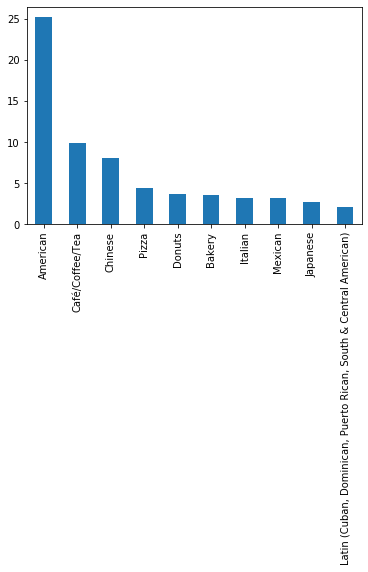

In [125]:
#Percentage of "low risk" restaurants that are each cuisine type
low_risk_cuisine_counts = under_ten['CUISINE DESCRIPTION'].value_counts()
low_risk_cuisine_percentage=(low_risk_cuisine_counts/7844)*100
fig, ax = plt.subplots()
low_risk_cuisine_percentage.head(10).plot(ax=ax, kind='bar')

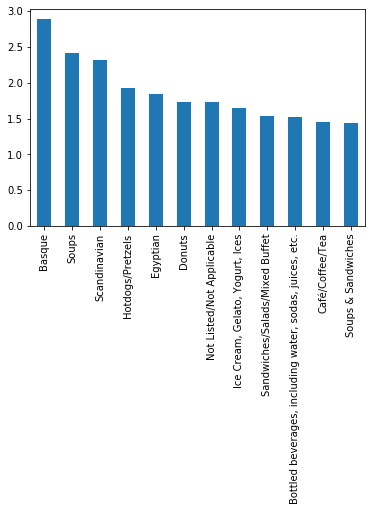

In [139]:
#Check the ration between the percentage in the low risk vs overall. 1 is same. Higher the better representation.
low_overall_ratio=low_risk_cuisine_percentage/cuisine_percentage
low_overall_ratio.sort_values(ascending= False, inplace = True)
fig, ax = plt.subplots()
low_overall_ratio.head(12).plot(ax=ax, kind='bar')

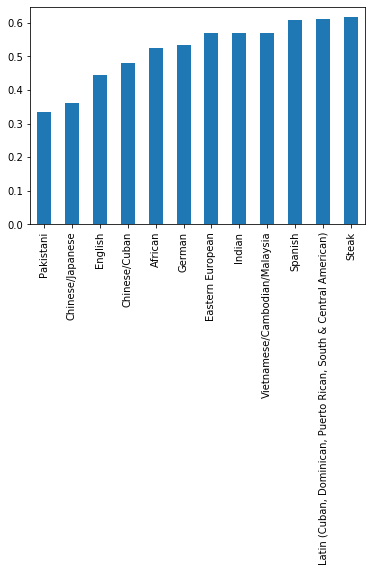

In [136]:
#Check the ration between the percentage in the low risk vs overall. 1 is same. Higher the better representation.
low_overall_ratio=low_risk_cuisine_percentage/cuisine_percentage
low_overall_ratio.sort_values(inplace = True)
fig, ax = plt.subplots()
low_overall_ratio.head(12).plot(ax=ax, kind='bar')

In [157]:
#Bootstrap to get the confidence interval for Latin, Mexican, and Japanese. 

latin_ratio_boot = np.zeros((1000,1))
mexican_ratio_boot = np.zeros((1000,1))
japanese_ratio_boot = np.zeros((1000,1))

for boot_sample in range (1000):
    under_ten_sample = under_ten.sample(frac=1, replace=True)
    
    mexican_counts = under_ten_sample.loc[under_ten_sample['CUISINE DESCRIPTION']=='Mexican']
    latin_counts = under_ten_sample.loc[under_ten_sample['CUISINE DESCRIPTION']=='Latin (Cuban, Dominican, Puerto Rican, South & Central American)']
    japanese_counts = under_ten_sample.loc[under_ten_sample['CUISINE DESCRIPTION']=='Japanese']
    
    mexican_percentage = (mexican_counts.shape[0]/under_ten_sample.shape[0])*100
    latin_percentage = (latin_counts.shape[0]/under_ten_sample.shape[0])*100
    japanese_percentage = (japanese_counts.shape[0]/under_ten_sample.shape[0])*100

    mexican_ratio_boot[boot_sample]=mexican_percentage/cuisine_percentage['Mexican']
    latin_ratio_boot[boot_sample]=latin_percentage/cuisine_percentage['Latin (Cuban, Dominican, Puerto Rican, South & Central American)']
    japanese_ratio_boot[boot_sample]=japanese_percentage/cuisine_percentage['Japanese']

    


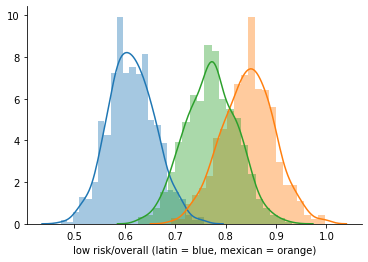

In [160]:
ax1=sb.distplot(latin_ratio_boot)
sb.despine()
ax1.set_xlabel('low risk/overall (latin = blue, mexican = orange, japanese = green)')

ax1=sb.distplot(mexican_ratio_boot)
sb.despine()

ax1=sb.distplot(japanese_ratio_boot)
sb.despine()

### Check places over  28 = C for initial inspection, consider them "high risk". Check if any cuisine type is over or under representated in this group.

In [141]:
#Defined as those with initial inspection score over 28.
over_28 = latest_initial_inspection.loc[latest_initial_inspection['SCORE']>=28]
over_28.shape

(3262, 26)

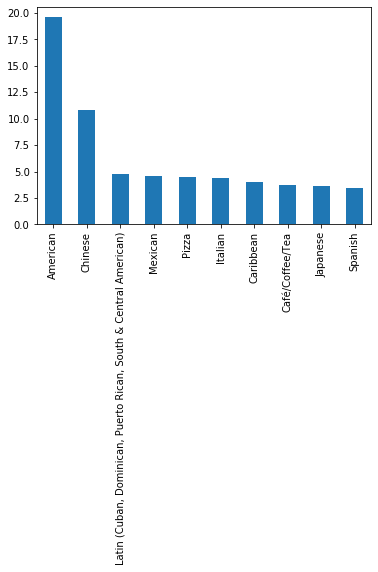

In [142]:
#Percentage of "high risk" restaurants that are each cuisine type
high_risk_cuisine_counts = over_28['CUISINE DESCRIPTION'].value_counts()
high_risk_cuisine_percentage=(high_risk_cuisine_counts/3262)*100
fig, ax = plt.subplots()
high_risk_cuisine_percentage.head(10).plot(ax=ax, kind='bar')

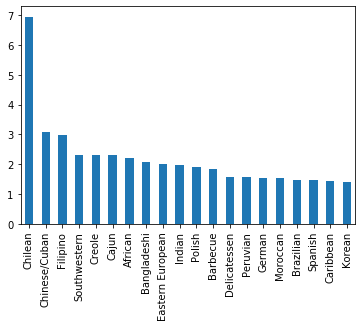

In [145]:
#Check the ration between the percentage in the high risk vs overall. 1 is same. Higher the larger representation.
high_overall_ratio=high_risk_cuisine_percentage/cuisine_percentage
high_overall_ratio.sort_values(ascending= False, inplace = True)
fig, ax = plt.subplots()
high_overall_ratio.head(20).plot(ax=ax, kind='bar')

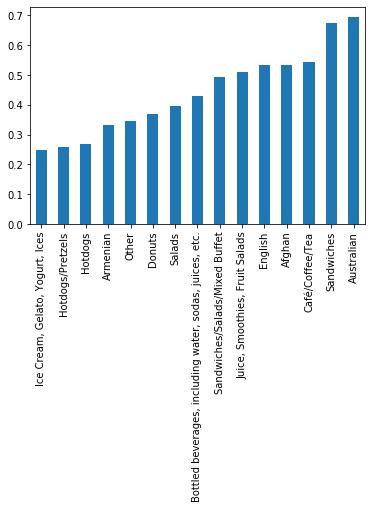

In [146]:
#Check the ration between the percentage in the high risk vs overall. 1 is same. Higher the larger representation.
high_overall_ratio=high_risk_cuisine_percentage/cuisine_percentage
high_overall_ratio.sort_values(inplace = True)
fig, ax = plt.subplots()
high_overall_ratio.head(15).plot(ax=ax, kind='bar')

## Results



- ### Donuts shops and Cafes are low risk.

- ### Latin and Spanish cuisines are under represented in the low risk group.

- ### Spanish and Caribbean cuisines are over represented in the high risk group.

- ### For future iterations, check the effects of the location and price range.

- ### Fast foods, drinks, easy to serve foods are in the low risk group.